In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/110-1-ntut-dl-app-hw3/IXIC.csv
/kaggle/input/110-1-ntut-dl-app-hw3/nasdaq_predict.csv
/kaggle/input/110-1-ntut-dl-app-hw3/qqq.us.txt


In [87]:
import cudf as pd
import cupy as cp
import cuml
from cuml import LinearRegression
from cuml.linear_model import LinearRegression
from cuml import Ridge
from cuml.linear_model import Ridge
from cuml.model_selection import train_test_split
from cuml.linear_model import Lasso
from cuml.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import TimeSeriesSplit

from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import numpy as np
import pandas as pd2 
import matplotlib.pylab as plt
import math

#from sklearn.linear_model import LinearRegression

# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

In [88]:
data = '/kaggle/input/110-1-ntut-dl-app-hw3/IXIC.csv'
df = pd.read_csv(data)
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...,...
12819,2021-12-02,15181.820313,15444.540039,15150.120117,15381.320313,15381.320313,5390100000
12820,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000
12821,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000
12822,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000


In [89]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 12824 entries, 0 to 12823
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Date       12824 non-null  object
 1   Open       12824 non-null  float64
 2   High       12824 non-null  float64
 3   Low        12824 non-null  float64
 4   Close      12824 non-null  float64
 5   Adj Close  12824 non-null  float64
 6   Volume     12824 non-null  int64
dtypes: float64(5), int64(1), object(1)
memory usage: 776.5+ KB


In [90]:
# number of rows and columns in the data set
df.shape

(12824, 7)

In [91]:
print("Null Value Present: ", df.isnull().values.any())

Null Value Present:  False


In [92]:
df.isnull().sum

<bound method Frame.sum of         Date   Open   High    Low  Close  Adj Close  Volume
0      False  False  False  False  False      False   False
1      False  False  False  False  False      False   False
2      False  False  False  False  False      False   False
3      False  False  False  False  False      False   False
4      False  False  False  False  False      False   False
...      ...    ...    ...    ...    ...        ...     ...
12819  False  False  False  False  False      False   False
12820  False  False  False  False  False      False   False
12821  False  False  False  False  False      False   False
12822  False  False  False  False  False      False   False
12823  False  False  False  False  False      False   False

[12824 rows x 7 columns]>

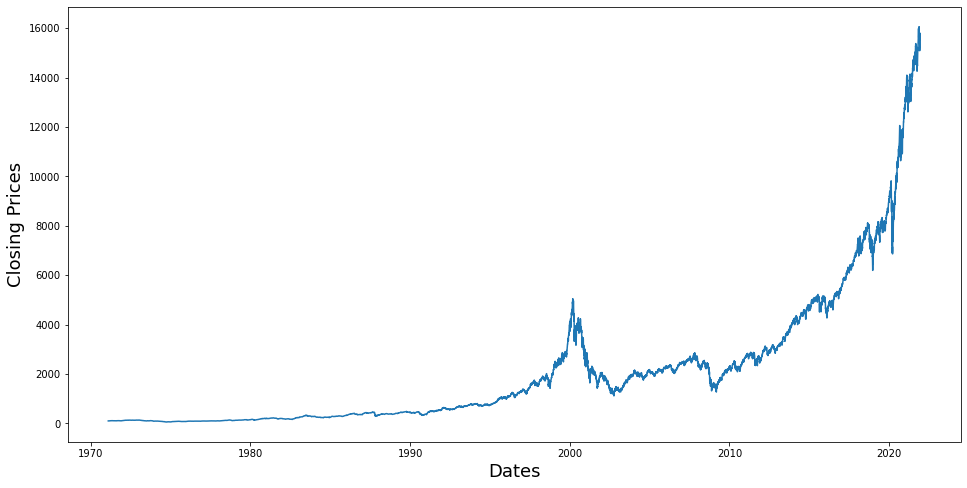

In [93]:
# Visualize the closing price history

data_plot = pd2.read_csv(data, sep=',', parse_dates=['Date'], index_col='Date')

plt.figure(figsize=(16,8))
plt.plot(data_plot['Close'])
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Closing Prices', fontsize=18)
plt.show()

In [94]:
# Creating a new dataframe with only the 'Close' column
df2 = pd2.read_csv(data)
new_df = df2.filter(['Close'])
# Converting the df to a numpy array 
dataset = new_df.values
# Divide the dataset such that 80% of rows go under training and rest 20% will be used for testing
training_data_len = math.ceil( len(dataset) * 0.8)

training_data_len

10260

In [11]:
# Scale the data (Feature Scaling)
scaler = MinMaxScaler(feature_range=(0,1))
# transforming our data 
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00282017],
       [0.00287266],
       [0.00286766],
       ...,
       [0.94799023],
       [0.97684619],
       [0.98309958]])

# LSTM 

In [29]:
# LSTMs expect our data to be in a specific format, usually a 3D array. 
# We start by creating data in 60 timesteps and converting it into an array using NumPy. 
# Next, we convert the data into a 3D dimension array with X_train samples, 60 timestamps, and one feature at each step.

# Creating the scaled training dataset 
train_data = scaled_data[0:training_data_len , :]

#splitting the data into X_train and y_train data sets 
X_train = []
Y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i,0])
    if i<=61:
        print(X_train)
        print(Y_train)
        print()


[array([0.00282017, 0.00287266, 0.00286766, 0.00286329, 0.00291078,
       0.00294828, 0.00295703, 0.0029289 , 0.00290891, 0.00286391,
       0.00280018, 0.00280267, 0.00286017, 0.00289703, 0.00290391,
       0.0029314 , 0.00293515, 0.00294953, 0.00299389, 0.00300764,
       0.0030845 , 0.00309575, 0.00307888, 0.00308638, 0.00310138,
       0.00314075, 0.00316762, 0.00316387, 0.00318761, 0.00318074,
       0.00315574, 0.0031395 , 0.00311387, 0.00310763, 0.003137  ,
       0.00314512, 0.00316012, 0.00319324, 0.00321636, 0.00324885,
       0.00326822, 0.0032926 , 0.00332384, 0.00334384, 0.00337446,
       0.00337321, 0.00338758, 0.0034257 , 0.00344257, 0.00345507,
       0.0034157 , 0.00341508, 0.00344445, 0.00348819, 0.00351569,
       0.00355068, 0.00359317, 0.0035988 , 0.0035888 , 0.00352943])]
[0.0035556786483360177]

[array([0.00282017, 0.00287266, 0.00286766, 0.00286329, 0.00291078,
       0.00294828, 0.00295703, 0.0029289 , 0.00290891, 0.00286391,
       0.00280018, 0.00280267, 0.

In [30]:
#convert the x_train and y_train to numpy array 
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [31]:
#Reshape the data 
#Our X_train is 2 dimensional , but LSTM model wants 3 dimensional
print(X_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(10200, 60)


(10200, 60, 1)

In [32]:
#Build the LSTM model 
# We add the LSTM layer and later add a few Dropout layers to prevent overfitting. 
# We add the LSTM layer with the following arguments:
# 1. 50 units which is the dimensionality of the output space
# 2. return_sequences=True which determines whether to return the last output in the output sequence, or the full sequence
# 3. input_shape as the shape of our training set.

# When defining the Dropout layers, we specify 0.2, meaning that 20% of the layers will be dropped.
# Thereafter, we add the Dense layer that specifies the output of 1 unit
# After this, we compile our model using the popular adam optimizer and set the loss as the mean_squarred_error.
# Next, we fit the model to run on 100 epochs with a batch size of 32

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))

model.add(Dense(1))

2022-03-16 16:25:43.670782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 16:25:43.675957: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 16:25:43.676762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 16:25:43.677950: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

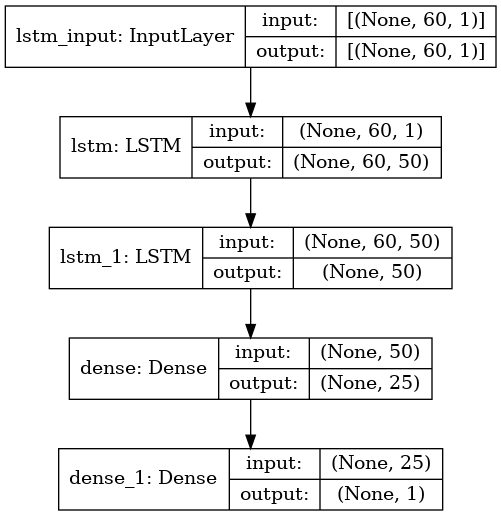

In [33]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [34]:
#Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')

In [35]:
#Train the model
model.fit(X_train, Y_train, batch_size=64, epochs=10, verbose=1)

2022-03-16 16:25:58.220873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-16 16:26:01.771541: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 [==============================] - 5s 8ms/step - loss: 2.3021e-04
Epoch 2/10
160/160 [==============================] - 1s 8ms/step - loss: 1.4404e-05
Epoch 3/10
160/160 [==============================] - 1s 8ms/step - loss: 1.3109e-05
Epoch 4/10
160/160 [==============================] - 1s 8ms/step - loss: 1.1874e-05
Epoch 5/10
160/160 [==============================] - 2s 10ms/step - loss: 1.3208e-05
Epoch 6/10
160/160 [==============================] - 1s 9ms/step - loss: 1.1251e-05
Epoch 7/10
160/160 [==============================] - 1s 8ms/step - loss: 1.2053e-05
Epoch 8/10
160/160 [==============================] - 1s 8ms/step - loss: 1.1424e-05
Epoch 9/10
160/160 [==============================] - 1s 8ms/step - loss: 1.1549e-05
Epoch 10/10
160/160 [==============================] - 1s 8ms/step - loss: 1.2286e-05


In [36]:
#Creating the scaled testing dataset from the remaining 20% 
test_data = scaled_data[training_data_len-60: , :]
#Create X_test and Y_test
X_test = []
Y_test = scaled_data[training_data_len: , :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

In [37]:
#Convert to numpy array 
X_test = np.array(X_test)

In [38]:
#Reshape the data 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [39]:
X_test.shape

(2564, 60, 1)

In [40]:
#Get the model's predicted price values 
predictions = model.predict(X_test)

In [41]:
#Evaluating the model using RMSE
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(Y_test, predictions)
rmse = math.sqrt(MSE)

In [42]:
rmse

0.02099621676844569

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


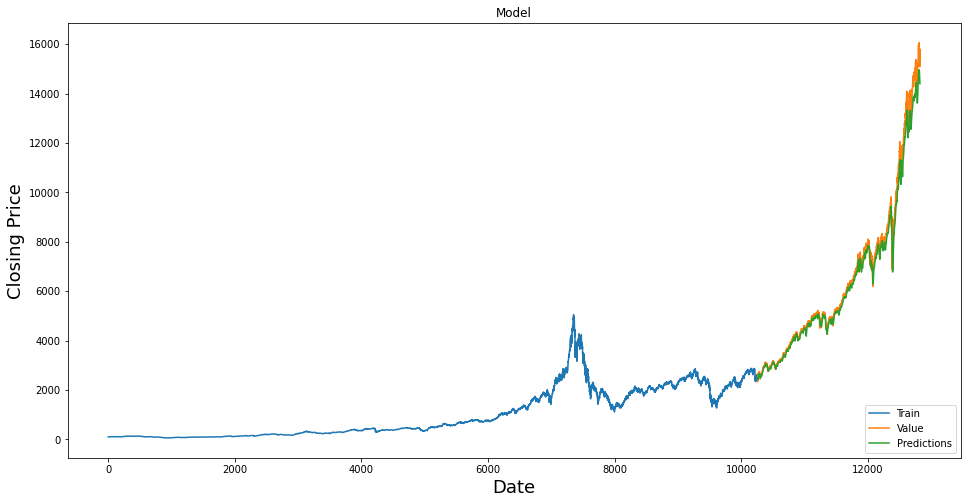

In [45]:
# Plot the data 
train = df2[: training_data_len]
valid = df2[training_data_len :]

#unscaling the values back to the orignal form
predictions = scaler.inverse_transform(predictions)

valid['Predictions'] = predictions

#Visualize the data 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Value', 'Predictions'], loc = 'lower right')
plt.show()


In [46]:
#Show the valid and predicted prices
valid

,Date,Open,High,Low,Close,Adj Close,Volume,Predictions
10260,2011-10-03,2401.189941,2430.879883,2335.229980,2335.830078,2335.830078,2547690000,2472.366455
10261,2011-10-04,2312.679932,2406.669922,2298.889893,2404.820068,2404.820068,3040940000,2445.549072
10262,2011-10-05,2398.370117,2466.500000,2380.959961,2460.510010,2460.510010,2472400000,2422.350830
10263,2011-10-06,2459.050049,2507.439941,2446.719971,2506.820068,2506.820068,2249140000,2409.241943
10264,2011-10-07,2509.610107,2512.139893,2468.600098,2479.350098,2479.350098,2084900000,2408.233643
...,...,...,...,...,...,...,...,...
12819,2021-12-02,15181.820313,15444.540039,15150.120117,15381.320313,15381.320313,5390100000,14673.454102
12820,2021-12-03,15428.709961,15470.360352,14931.059570,15085.469727,15085.469727,5859520000,14592.702148
12821,2021-12-06,15117.629883,15281.990234,14931.610352,15225.150391,15225.150391,5095960000,14489.077148
12822,2021-12-07,15510.910156,15720.089844,15507.660156,15686.919922,15686.919922,5091220000,14404.048828


In [48]:
# predicting the final closing price
data_2 = df2

new_df_2 = data_2.filter(['Close'])

temp = new_df_2[-60:].values
temp_scaled = scaler.transform(temp)
X_test_2 = []
X_test_2.append(temp_scaled)
X_test_2 = np.array(X_test_2)
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], X_test_2.shape[1], 1))
final_y_predict = model.predict(X_test_2)
final_y_predict = scaler.inverse_transform(final_y_predict)
print(final_y_predict)

[[14430.29]]


/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


# Linear Regression 

In [12]:
#Set Target Variable
output_var = pd2.DataFrame(df2['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

In [25]:
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df2[features])
output_var_scaled = scaler.fit_transform(output_var)
feature_transform= pd2.DataFrame(columns=features, data=feature_transform, index=df2.index)
feature_transform.head()

,Open,High,Low,Volume
0,0.002809,0.002793,0.002827,0.0
1,0.002861,0.002845,0.002880,0.0
2,0.002856,0.002840,0.002875,0.0
3,0.002852,0.002836,0.002871,0.0
4,0.002899,0.002883,0.002918,0.0


In [26]:
output_var_scaled

array([[0.00282017],
       [0.00287266],
       [0.00286766],
       ...,
       [0.94799023],
       [0.97684619],
       [0.98309958]])

In [51]:
X_train = feature_transform[: training_data_len]
X_test = feature_transform[training_data_len : ]

Y_train = output_var_scaled[: training_data_len]
Y_test = output_var_scaled[training_data_len : ]

In [28]:
#All linear Regression Algorithms
algorithm = ['svd', 'eig', 'svd-qr', 'svd-jacobi']

#Evaluation Metrics for all 5 algorithms
for i in algorithm:
    print("Algorithm:")
    print(i)
    lr = LinearRegression(fit_intercept = True, normalize = False, algorithm = i)
    reg = lr.fit(X_train,Y_train)
    preds = lr.predict(X_test)
    print("RMSE:")
    print(np.sqrt(cuml.metrics.regression.mean_squared_error(Y_test.astype('int64'),preds.astype('int64'))))

Algorithm:
svd
RMSE:
0.02792359176235374
Algorithm:
eig
RMSE:
0.02792359176235374
Algorithm:
svd-qr
RMSE:
0.02792359176235374
Algorithm:
svd-jacobi
RMSE:
0.02792359176235374


# Ridge Regression

In [52]:
alpha = cp.array([1e-5])
ridge1 = Ridge(alpha = alpha, fit_intercept = True, normalize = False,
solver = "eig")
model1=ridge1.fit(X_train,Y_train)
y_pred_ridge1=model1.predict(X_test)

print(np.sqrt(cuml.metrics.regression.mean_squared_error(Y_test.astype('int64'),y_pred_ridge1.astype('int64'))))

0.02792359176235374


In [53]:
alpha = cp.array([1e-5])
ridge2 = Ridge(alpha = alpha, fit_intercept = True, normalize = False,
solver = "svd")
model2=ridge2.fit(X_train,Y_train)
y_pred_ridge2=model2.predict(X_test)

print(np.sqrt(cuml.metrics.regression.mean_squared_error(Y_test.astype('int64'),y_pred_ridge2.astype('int64'))))

0.02792359176235374


# Lasso Regression

In [54]:
ls = Lasso(alpha = 0.1)
result_lasso = ls.fit(X_train, Y_train)
y_pred_lasso=result_lasso.predict(X_test)

print(np.sqrt(cuml.metrics.regression.mean_squared_error(Y_test.astype('int64'),y_pred_lasso.astype('int64'))))

0.01974881263833411


# k-Nearest Neighbours

In [65]:
# Taking the same training and testing data 
X_train = feature_transform[: training_data_len]
X_test = feature_transform[training_data_len : ]

Y_train = output_var_scaled[: training_data_len]
Y_test = output_var_scaled[training_data_len : ]

In [66]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

In [67]:
#fit the model and make predictions
model.fit(X_train,Y_train)
predictions = model.predict(X_test)

In [68]:
#rmse
rmse = np.sqrt(np.mean(np.power((np.array(Y_test)-np.array(predictions)),2)))
rmse

0.22254486928905837

In [184]:
valid.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Predictions
10260,2011-10-03,2401.189941,2430.879883,2335.229980,2335.830078,2335.830078,2547690000,2350.755005
10261,2011-10-04,2312.679932,2406.669922,2298.889893,2404.820068,2404.820068,3040940000,2357.214966
10262,2011-10-05,2398.370117,2466.500000,2380.959961,2460.510010,2460.510010,2472400000,2469.709961
10263,2011-10-06,2459.050049,2507.439941,2446.719971,2506.820068,2506.820068,2249140000,2448.660034
10264,2011-10-07,2509.610107,2512.139893,2468.600098,2479.350098,2479.350098,2084900000,2485.765014


# Random Forest Regression Model

In [ ]:
# Taking the same training and testing data 
X_train = feature_transform[: training_data_len]
X_test = feature_transform[training_data_len : ]

Y_train = output_var_scaled[: training_data_len]
Y_test = output_var_scaled[training_data_len : ]

In [83]:
forest_regressor = RandomForestRegressor(n_estimators = 250)
forest_regressor.fit(X_train.values.astype('float32'), Y_train.astype('float32'))

y_pred_random= forest_regressor.predict(X_test)

print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(Y_test, y_pred_random)), 4))

Root Mean Squared Error: 0.236


# XGBOOST Regressor

In [ ]:
# Taking the same training and testing data 
X_train = feature_transform[: training_data_len]
X_test = feature_transform[training_data_len : ]

Y_train = output_var_scaled[: training_data_len]
Y_test = output_var_scaled[training_data_len : ]

In [101]:
model = XGBRegressor()

model.fit(X_train, Y_train)

predict = model.predict(X_test)

print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(Y_test, predict)), 4))

Root Mean Squared Error: 0.2205
